# Prepare data

NaN values in X: tensor(True)
NaN values in Y: tensor(True)
Infinite values in X: tensor(False)
Infinite values in Y: tensor(False)
NaN values in X: tensor(False)
NaN values in Y: tensor(False)
Number of elements removed due to containing NaN values: 160


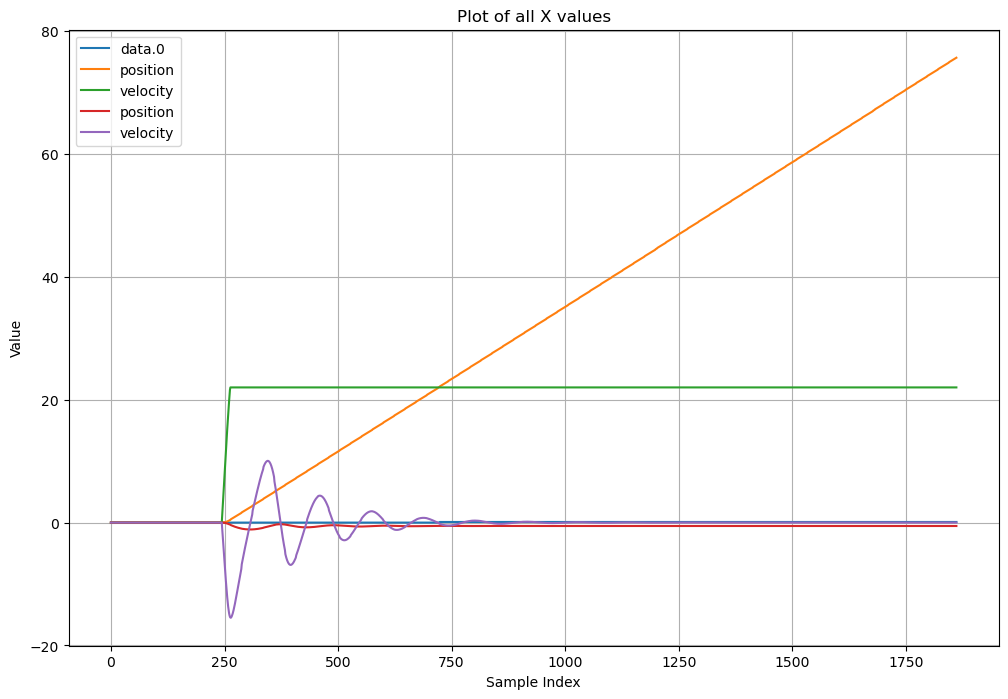

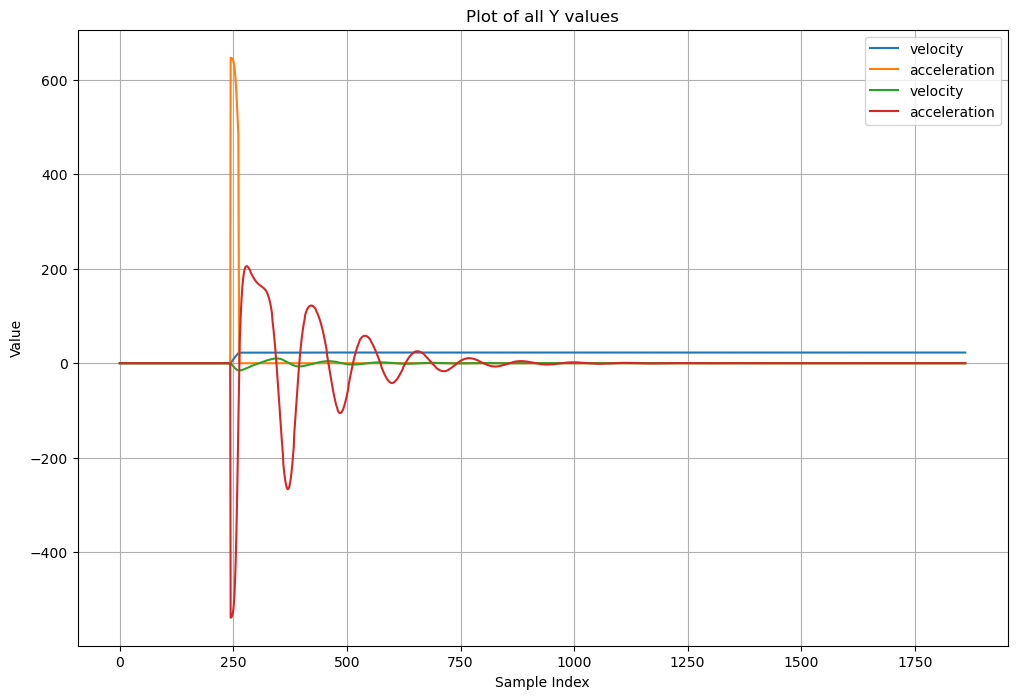

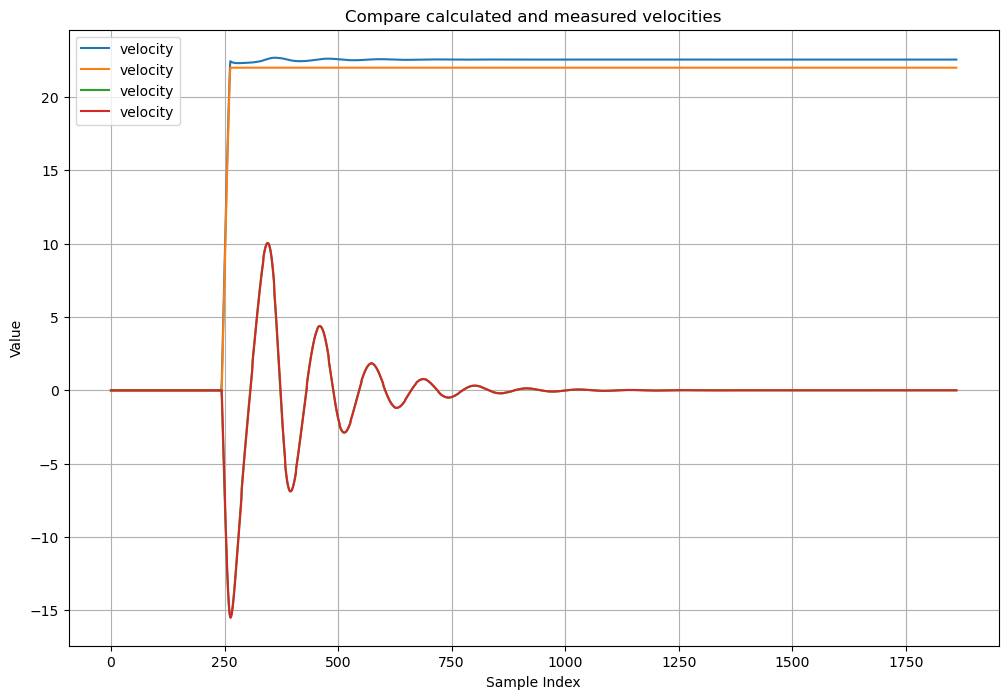

In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from ament_index_python.packages import get_package_share_directory


# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, csv_file, x_columns, y_columns, starting_idx):
        self.data = pd.read_csv(
            csv_file, skiprows=range(1, starting_idx)
        )  # Skip first 'starting_idx' rows
        self.x_columns = x_columns
        self.y_columns = y_columns

        self.modify_data()

    def __len__(self):
        return len(self.data) - 1  # Exclude the last element

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        next_sample = self.data.iloc[idx + 1]

        x_data = torch.tensor(sample[self.x_columns], dtype=torch.float32)

        # Extract Y data (derivative)
        time_col = "/joint_states_sim/header/stamp"
        # time_col = "__time"
        dt = next_sample[time_col] - sample[time_col]
        y_derivative = torch.tensor(
            [(next_sample[col] - sample[col]) / dt for col in self.y_columns],
            dtype=torch.float32
        )

        return x_data, y_derivative

    def modify_data(self):
        control_value_found = False
        for idx, row in self.data.iterrows():
            if row["/effort_control_sim/data.0"] == 0.1:
                control_value_found = True

            if control_value_found:
                self.data.at[idx, "/effort_control_sim/data.0"] = 0.1
            else:
                self.data.at[idx, "/effort_control_sim/data.0"] = 0.0


# Define the file path
oscillations_file = os.path.join(
    get_package_share_directory("furuta_pendulum_model"),
    "data",
    "simulation_step_response_01_22limit.csv",
)

# Define the starting index
starting_idx = 100

# Load the data from the CSV file, starting from the specified index
df = pd.read_csv(oscillations_file, skiprows=range(1, starting_idx))

# Define the target columns for X and Y data
x_columns = [
    "/effort_control_sim/data.0",
    "/joint_states_sim/joint0/position",
    "/joint_states_sim/joint0/velocity",
    "/joint_states_sim/joint1/position",
    "/joint_states_sim/joint1/velocity",
]
y_columns = [
    "/joint_states_sim/joint0/position",
    "/joint_states_sim/joint0/velocity",
    "/joint_states_sim/joint1/position",
    "/joint_states_sim/joint1/velocity",
]
y_labels = [
    "velocity",
    "acceleration",
    "velocity",
    "acceleration",
]

# Create the custom dataset
dataset = CustomDataset(oscillations_file, x_columns, y_columns, starting_idx)

print("NaN values in X:", torch.isnan(torch.stack([x for x, _ in dataset])).any())
print("NaN values in Y:", torch.isnan(torch.stack([y for _, y in dataset])).any())
print("Infinite values in X:", torch.isinf(torch.stack([x for x, _ in dataset])).any())
print("Infinite values in Y:", torch.isinf(torch.stack([y for _, y in dataset])).any())

# Remove samples with NaN values from the dataset
clean_dataset = [(x, y) for x, y in dataset if not (torch.isnan(x).any() or torch.isnan(y).any())]

# Check if there are any NaN values remaining in the cleaned dataset
print("NaN values in X:", torch.isnan(torch.stack([x for x, _ in clean_dataset])).any())
print("NaN values in Y:", torch.isnan(torch.stack([y for _, y in clean_dataset])).any())

# Count the number of elements removed due to containing NaN values
num_removed_elements = len(dataset) - len(clean_dataset)
print("Number of elements removed due to containing NaN values:", num_removed_elements)

dataset = clean_dataset

# Create vectors of X and Y values
all_x_values = []
all_y_values = []
for i in range(len(dataset)):
    x_data, y_data = dataset[i]
    all_x_values.append(x_data.numpy())
    all_y_values.append(y_data.numpy())

# Plot all X values
plt.figure(figsize=(12, 8))

for i in range(len(x_columns)):
    plt.plot([x[i] for x in all_x_values], label=x_columns[i].split("/")[-1])

plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.title("Plot of all X values")
plt.legend()
plt.grid(True)
plt.show()

# Plot all Y values
plt.figure(figsize=(12, 8))

for i in range(len(y_columns)):
    plt.plot([y[i] for y in all_y_values], label=y_labels[i].split("/")[-1])

plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.title("Plot of all Y values")
plt.legend()
plt.grid(True)
plt.show()

# Plot all Y values
plt.figure(figsize=(12, 8))

for i in [0, 2]:
    plt.plot([y[i] for y in all_y_values], label=y_labels[i].split("/")[-1])
    plt.plot([x[i + 2] for x in all_x_values], label=x_columns[i + 2].split("/")[-1])

plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.title("Compare calculated and measured velocities")
plt.legend()
plt.grid(True)
plt.show()

# Training neural net

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)  # Increase the size of the first hidden layer
        self.fc2 = nn.Linear(256, 256)         # Add another hidden layer
        self.fc3 = nn.Linear(256, 256)         # Add another hidden layer
        self.fc4 = nn.Linear(256, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Define the input and output sizes
input_size = len(dataset[0][0])
output_size = len(dataset[0][1])

# Create the neural network
# model = SimpleNN(input_size, output_size).to(device)
model = SimpleNN(input_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the data loader
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Train the neural network
num_epochs = 1000
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss}")

print("Finished Training")


Epoch 1, Loss: 58309.477111816406
Epoch 2, Loss: 55571.77081298828
Epoch 3, Loss: 53577.95726633072
Epoch 4, Loss: 51365.88656616211
Epoch 5, Loss: 48068.10289001465
Epoch 6, Loss: 44904.33517456055
Epoch 7, Loss: 40269.9953918457
Epoch 8, Loss: 34615.59133911133
Epoch 9, Loss: 33012.176054000854
Epoch 10, Loss: 33993.935196876526
Epoch 11, Loss: 24348.287355422974
Epoch 12, Loss: 21882.699731826782
Epoch 13, Loss: 18972.794731140137
Epoch 14, Loss: 17528.663772583008
Epoch 15, Loss: 19729.43943786621
Epoch 16, Loss: 18199.85703754425
Epoch 17, Loss: 16125.50993347168
Epoch 18, Loss: 16879.37483215332
Epoch 19, Loss: 16336.137619018555
Epoch 20, Loss: 15288.973266601562
Epoch 21, Loss: 15880.609184265137
Epoch 22, Loss: 15787.205011367798
Epoch 23, Loss: 13942.182174682617
Epoch 24, Loss: 18242.332412719727
Epoch 25, Loss: 15815.917236328125
Epoch 26, Loss: 36741.536613464355
Epoch 27, Loss: 23007.164058685303
Epoch 28, Loss: 12005.468278884888
Epoch 29, Loss: 11235.513488769531
Epoch 

In [6]:

import torch
from torchdiffeq import odeint
import matplotlib.pyplot as plt

def f(t, x):
    with torch.no_grad():  # Ensure no gradient tracking
        return torch.cat((torch.zeros(1), model(x)))

# Initial condition
x0 = torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0])

# Time points
t = torch.linspace(0, 2, 1000)

# Integrate using odeint
out = odeint(f, x0, t)

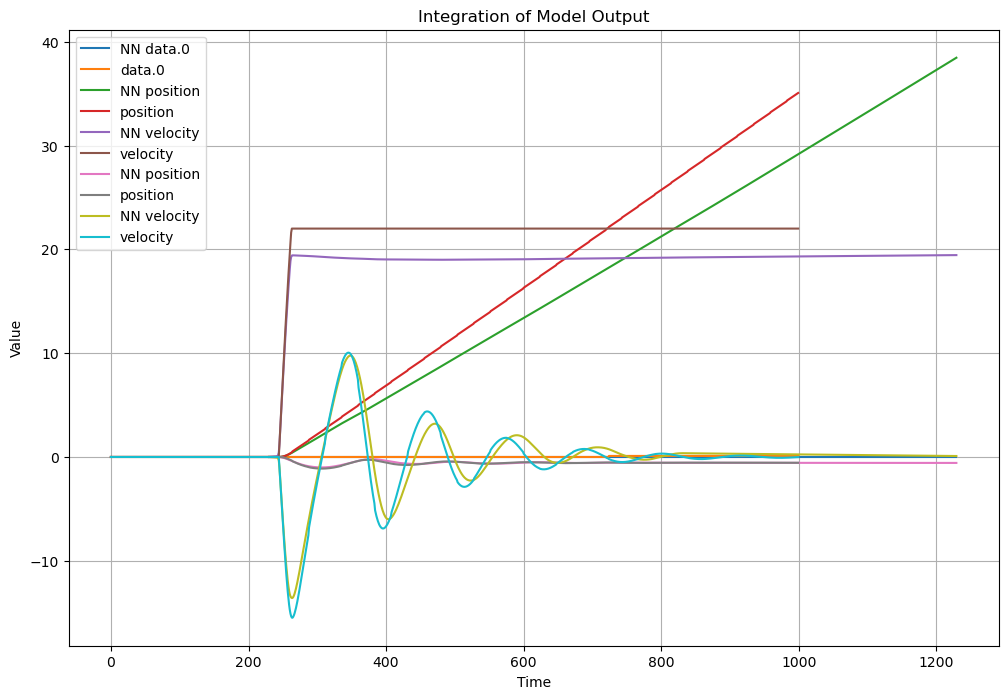

In [13]:
# Plot the results
plt.figure(figsize=(12, 8))

for i in range(len(out[0])):
    offset = 230
    plt.plot(
        range(offset, len(out) + offset),
        out[:, i].detach().numpy(),
        label="NN " + x_columns[i].split("/")[-1],
    )
    plt.plot(
        range(0, len(out)),
        [all_x_values[j][i] for j in range(len(out))],
        label=x_columns[i].split("/")[-1],
    )

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Integration of Model Output")
plt.legend()
plt.grid(True)
plt.show()